Tutorial: Raster-scan simulations - photonic LDOS
===============================
This is an example how to simulate photonic LDOS raster-scans in pyGDM.

We load the pyGDM modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import nonlinear
from pyGDM2 import visu
from pyGDM2 import tools

Simulation setup
------------------

We will setup two simulations: One to calculate a decay-rate mapping (i.e. the LDOS) and a second for a "TPL"-type rasterscan. The latter can be used to get an approximation for the LDOS at the surface of the structure (see e.g. [1]).


[1] Viarbitskaya, S. et al. *Tailoring and imaging the plasmonic local density of states in crystalline nanoprisms.* Nat. Mater. **12**, 426–432 (2013)

/home/hans/Documents/programming/work/python/pyGDM2/structures.py:101: UserWarning: Minimum structure Z-value lies below substrate level! Shifting structure bottom to Z=step/2.
  " Shifting structure bottom to Z=step/2.")


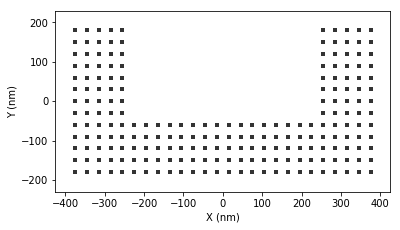

N dipoles: 420


In [2]:
## ---------- Setup structure
mesh = 'cube'
## -- note: in the paper example, a stepsize of 20nm was used. 
##          We increase the step for the sake of a shorter simulation runtime.
step = 30.0
geometry = structures.rect_split_ring(step, L1=800/step-1, L2=400/step-1, 
                                         W=180/step-1, H=int(60/step), mesh=mesh)

material = materials.dummy(2.0)

n1, n2 = 1.0, 1.0  # constant environment

struct = structures.struct(step, geometry, material, n1,n2, structures.get_normalization(mesh))
struct = structures.center_struct(struct)

## --- raster-scan height: at top-surface of structure
Z_scan = geometry.T[2].max()
MAP = tools.generate_NF_map(-550,550,25, -310,310,15, Z_scan)

## ---------- Setup incident field at each raster-scan position
kwargs_focused = []
kwargs_dipole = []
for x,y,z in MAP.T:
    ## keys for focused illumination (TPL-method)
    kwargs_focused.append( dict(theta=0, spotsize=100, kSign=-1, xSpot=x, ySpot=y) )
    kwargs_focused.append( dict(theta=90, spotsize=100, kSign=-1, xSpot=x, ySpot=y) )
    
    ## keys for dipole emitter scan ("real" LDOS)
    kwargs_dipole.append( dict(x0=x, y0=y, z0=z, mx=0,my=0,mz=0) )


wavelengths = [600]
efield_focused = fields.efield(fields.focused_planewave, wavelengths=wavelengths, kwargs=kwargs_focused)
efield_dipole = fields.efield(fields.dipole_electric, wavelengths=wavelengths, kwargs=kwargs_dipole)


## ---------- Simulation initialization
sim_foc = core.simulation(struct, efield_focused)
sim_dp = core.simulation(struct, efield_dipole)


## --- plot the structure
visu.structure(sim_foc.struct.geometry, scale=0.5)
print "N dipoles:", len(sim_foc.struct.geometry)

Let's run the simulations:
----------------------------

In [3]:
## scattering (TPL method)
E0 = core.scatter(sim_foc, verbose=True)

## decay rate (LDOS)
SP0 = core.decay_rate(sim_dp, verbose=True)

timing 600.00nm:     2291.8 ms
Wavelength: 600.0nm - electric dipole
  - inversion:            0.128s


/home/hans/Documents/programming/work/python/pyGDM2/core.py:519: UserWarning: The dipole orientation is configured multiple times. This setting will be ignored by `core.decay_rate`. Please use `linear.decay` to compute the decay-rates for several dipole orientations.
  "several dipole orientations.")


  - decay repropagation:  15.171s


Note that *core.scatter* and *core.decay_rate* calculated $(2 + 1) \times 25 \times 15 = 1125$ simulations.

Calcuate raster-scan maps
---------------------------
Now comes the part where we calculate the scalar raster-scan maps from the simulation results

In [4]:

## --- calculate TPL rasterscan maps
TPL0 = tools.calculate_rasterscan(sim_foc, 0, nonlinear.tpl_ldos, nonlin_order=1, verbose=True)
TPL90 = tools.calculate_rasterscan(sim_foc, 1, nonlinear.tpl_ldos, nonlin_order=1, verbose=True)

## --- calculate decay-rate rasterscan maps
gamma_scan_X = linear.decay_eval(sim_dp, 0, 1, 0, 0, verbose=True)
gamma_scan_Y = linear.decay_eval(sim_dp, 0, 0, 1, 0, verbose=True)

decay-rate evaluated using:
  - wavelength: 600.0nm
  - dipole type: electric
  - dipole vector: (1, 0, 0)
decay-rate evaluated using:
  - wavelength: 600.0nm
  - dipole type: electric
  - dipole vector: (0, 1, 0)


/home/hans/Documents/programming/work/python/pyGDM2/tools.py:1102: UserWarning: 'field_kwargs' are index instead of dict.Using `get_possible_field_params_rasterscan`.Using configuration #0: '{'theta': 0, 'spotsize': 100, 'kSign': -1, 'wavelength': 600.0}'
  "Using configuration #{}: '{}'".format(kw_index, field_kwargs))
/home/hans/Documents/programming/work/python/pyGDM2/tools.py:1102: UserWarning: 'field_kwargs' are index instead of dict.Using `get_possible_field_params_rasterscan`.Using configuration #1: '{'theta': 90, 'spotsize': 100, 'kSign': -1, 'wavelength': 600.0}'
  "Using configuration #{}: '{}'".format(kw_index, field_kwargs))


Plotting the maps
-------------------
Now we have calculated 2D scalar maps of the LDOS in a plane at the level of the top surface of the structure. Let's plot it together with the surface LDOS obtained by the "TPL-method":

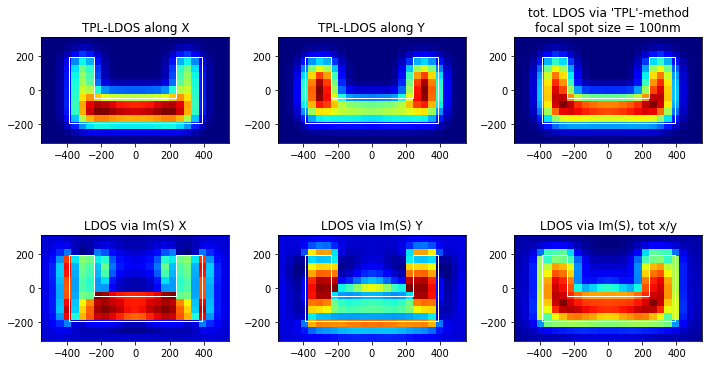

In [5]:
plt.figure(figsize=(10,6))

## --- plot "TPL-LDOS"
plt.subplot(231, aspect='equal'); plt.title("TPL-LDOS along X")
visu.scalarfield(TPL0, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)


plt.subplot(232, aspect='equal'); plt.title("TPL-LDOS along Y")
visu.scalarfield(TPL90, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)


TPL_tot = [TPL0[0], (TPL0[1]+TPL90[1])/2.]

plt.subplot(233)
plt.title("tot. LDOS via 'TPL'-method\nfocal spot size = {}nm".format(int(sim_foc.efield.kwargs[0]['spotsize'])))
visu.scalarfield(TPL_tot, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)



## --- plot LDOS via field-susceptibility ("decay-rate method")
plt.subplot(234)
plt.title("LDOS via Im(S) X")
visu.scalarfield(gamma_scan_X, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)


plt.subplot(235)
plt.title("LDOS via Im(S) Y")
visu.scalarfield(gamma_scan_Y, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)


gamma_scan_tot = gamma_scan_X
gamma_scan_tot.T[3] += gamma_scan_Y.T[3]
gamma_scan_tot.T[3] /= 2.0

plt.subplot(236)
plt.title("LDOS via Im(S), tot x/y")
visu.scalarfield(gamma_scan_tot, cmap='jet', show=False)
visu.structure_contour(sim_dp, color='w', input_mesh=mesh, show=False)


plt.tight_layout()
plt.show()

The agreement is qualitatively ok, the global trends are similar. The TPL-method gives however only an approximation to the LDOS at the surface. Also only the LDOS at the actual surface of the structure can be obtained using the TPL method with an unphysically tight beam. The LDOS *outside* the structure must in any case be calculated using the slower technique via the imaginary part of the field susceptibility (decay rate).